### Research Question 1: Does TSNE help us improve the "quality" of our clustering?

Quality is defined as the clustering seeming continuous to human observers
Due the difficulty of visualizing continuity in high dimensions, we may use the clustering's v measure score for categorical datasets which have sufficient "seperation", i.e. the classifications are not ordinal 

### Experiment 1:

Research Question:
Does TSNE help us to cluster well seperated data better?

The hand gestures dataset contains data for hand gestures are categorical, and the hand gestures are sufficiently distinct. It is well suited for testing via v_measure

- Run the algorithm, with TSNE, for 200 iterations, on the dataset
- check the v measure score
- Run the algorithm without TSNE, for 200 iterations, on the dataset
- check the v measure score
- Make note of the time taken, may be useful in the future when evaluating whether increased timecost is worthwhile

if the TSNE improves v measure score, then TSNE contributes to improved clustering
if it has no effect, it is unnecessary cost
if it makes it worse, the heuristic we are giving the algorithm results in dimension reduction that warp the clusters

due to many of these processes being random, we may need to run multiple times

Repeat if needed for other dimension reduction algorithms

In [1]:
import os

# change working directory, run this cell once
os.chdir("../")

# supress warnings
import warnings
warnings.filterwarnings("ignore")

In [19]:
from autocluster import AutoCluster
from evaluators import get_evaluator
from sklearn import datasets
from collections import Counter
from utils.metafeatures import MetafeatureMapper
from sklearn.metrics.cluster import v_measure_score
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
df = pd.read_csv("../data/hand_gestures_classification_merged.csv")
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,class
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0


In [21]:
df = df.sample(frac=0.1, random_state=27)
df.shape

(1168, 65)

In [22]:
X = df.loc[:, '0':'63']
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
2678,-24.0,0.0,1.0,4.0,1.0,-7.0,-7.0,-3.0,-5.0,3.0,...,13.0,21.0,-1.0,2.0,1.0,5.0,-17.0,-1.0,-37.0,-39.0
10005,-10.0,-8.0,-12.0,-18.0,-15.0,2.0,-4.0,-15.0,1.0,1.0,...,-20.0,4.0,-16.0,-5.0,2.0,5.0,-20.0,24.0,2.0,-57.0
7835,-14.0,14.0,1.0,1.0,-13.0,0.0,4.0,4.0,-12.0,-19.0,...,-5.0,-21.0,2.0,-12.0,-9.0,1.0,26.0,22.0,-9.0,6.0
3319,7.0,2.0,3.0,2.0,-26.0,-18.0,1.0,3.0,4.0,-2.0,...,0.0,-2.0,-21.0,-1.0,0.0,-2.0,30.0,-1.0,-1.0,-14.0
11380,-5.0,-1.0,-4.0,-2.0,5.0,12.0,-2.0,-23.0,-1.0,-3.0,...,-4.0,3.0,-9.0,-4.0,-6.0,-6.0,26.0,-30.0,3.0,-10.0


In [23]:
X.shape

(1168, 64)

In [24]:
y = df.loc[:,'class']
y.head(5)

2678     0
10005    3
7835     2
3319     1
11380    3
Name: class, dtype: int64

In [25]:
y.shape

(1168,)

In [34]:
cluster = AutoCluster()
fit_params = {
    "df": X, 
    "cluster_alg_ls": [
        'KMeans', 'GaussianMixture', 'Birch', 
        'MiniBatchKMeans', 'AgglomerativeClustering', 'SpectralClustering'
    ], 
    "dim_reduction_alg_ls": [
        'NullModel',
        'PCA', 'IncrementalPCA', 
        'KernelPCA', 'FastICA', 'TruncatedSVD'
    ],
    "optimizer": 'smac',
    "n_evaluations": 100,
    "run_obj": 'quality',
    "seed": 27,
    "cutoff_time": 180,
    "preprocess_dict": {
        "numeric_cols": [str(i) for i in range(64)],
        "categorical_cols": [],
        "ordinal_cols": [],
        "y_col": []
    },
    "evaluator": get_evaluator(evaluator_ls = ['silhouetteScore'], 
                               weights = [], clustering_num = None, 
                               min_proportion = .01),
    "n_folds": 3,
    "warmstart": True,
    "warmstart_datasets_dir": 'benchmark_silhouette',
    "warmstart_metafeatures_table_path": 'metaknowledge/benchmark_silhouette_metafeatures_table.csv',
    "warmstart_n_neighbors": 10,
    "warmstart_top_n": 3,
    "general_metafeatures": MetafeatureMapper.getGeneralMetafeatures(),
    "numeric_metafeatures": MetafeatureMapper.getNumericMetafeatures(),
    "categorical_metafeatures": [],
    "verbose_level": 1,
}
result_dict = cluster.fit(**fit_params)

1051/1168 datapoints remaining after outlier removal
Found 18 relevant intial configurations from warmstarter.
Truncated n_evaluations: 100
Fitting configuration: 
{'branching_factor___Birch': 291, 'clustering_choice': 'Birch', 'algorithm___TruncatedSVD': 'randomized', 'dim_reduction_choice': 'TruncatedSVD', 'n_clusters___Birch': 45, 'n_components___TruncatedSVD': 9}
Score obtained by this configuration: inf


Fitting configuration: 
{'branching_factor___Birch': 74, 'clustering_choice': 'Birch', 'algorithm___TruncatedSVD': 'randomized', 'dim_reduction_choice': 'TruncatedSVD', 'n_clusters___Birch': 71, 'n_components___TruncatedSVD': 6}
Score obtained by this configuration: inf


Fitting configuration: 
{'eigen_solver___SpectralClustering': 'arpack', 'random_state___NullModel': 1, 'clustering_choice': 'SpectralClustering', 'affinity___SpectralClustering': 'sigmoid', 'dim_reduction_choice': 'NullModel', 'assign_labels___SpectralClustering': 'kmeans', 'n_clusters___SpectralClustering': 76}


Process pynisher function call:
Traceback (most recent call last):
  File "/home/wywongbd/anaconda3/envs/automl/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/wywongbd/anaconda3/envs/automl/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wywongbd/anaconda3/envs/automl/lib/python3.5/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/wywongbd/autocluster/autocluster/autocluster.py", line 257, in evaluate_model
    scaler, dim_reduction_model, clustering_model = fit_models(cfg, train_data)
  File "/home/wywongbd/autocluster/autocluster/autocluster.py", line 225, in fit_models
    clustering_model.fit(compressed_data)
  File "/home/wywongbd/anaconda3/envs/automl/lib/python3.5/site-packages/sklearn/cluster/spectral.py", line 493, in fit
    assign_labels=self.assign_labels)
  File "/home

Fitting configuration: 
{'branching_factor___Birch': 55, 'clustering_choice': 'Birch', 'algorithm___TruncatedSVD': 'randomized', 'dim_reduction_choice': 'TruncatedSVD', 'n_clusters___Birch': 78, 'n_components___TruncatedSVD': 8}
Score obtained by this configuration: inf


Fitting configuration: 
{'branching_factor___Birch': 814, 'clustering_choice': 'Birch', 'n_clusters___Birch': 40, 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'linear', 'n_components___KernelPCA': 7}
Score obtained by this configuration: inf


Fitting configuration: 
{'branching_factor___Birch': 227, 'clustering_choice': 'Birch', 'algorithm___TruncatedSVD': 'randomized', 'dim_reduction_choice': 'TruncatedSVD', 'n_clusters___Birch': 46, 'n_components___TruncatedSVD': 7}
Score obtained by this configuration: inf


Fitting configuration: 
{'branching_factor___Birch': 149, 'clustering_choice': 'Birch', 'algorithm___TruncatedSVD': 'randomized', 'dim_reduction_choice': 'TruncatedSVD', 'n_clusters___Birch': 38, 'n_components___TruncatedSVD': 5}
Score obtained by this configuration: inf


Fitting configuration: 
{'branching_factor___Birch': 64, 'clustering_choice': 'Birch', 'n_clusters___Birch': 25, 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'linear', 'n_components___KernelPCA': 8}
Score obtained by this configuration: inf


Fitting configuration: 
{'branching_factor___Birch': 857, 'clustering_choice': 'Birch', 'batch_size___IncrementalPCA': 748, 'n_clusters___Birch': 59, 'dim_reduction_choice': 'IncrementalPCA', 'n_components___IncrementalPCA': 3}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'average', 'n_clusters___AgglomerativeClustering': 16, 'affinity___AgglomerativeClustering': 'cityblock', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 8, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 7, 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'rbf', 'n_components___KernelPCA': 6, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'single', 'n_clusters___AgglomerativeClustering': 6, 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'rbf', 'n_components___KernelPCA': 4, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'single', 'n_clusters___AgglomerativeClustering': 7, 'affinity___AgglomerativeClustering': 'l2', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'rbf', 'n_components___KernelPCA': 4, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 72, 'random_state___NullModel': 1, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'svd_solver___PCA': 'auto', 'n_components___PCA': 2, 'whiten___PCA': True, 'clustering_choice': 'Birch', 'branching_factor___Birch': 17, 'n_clusters___Birch': 1, 'dim_reduction_choice': 'PCA'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_components___GaussianMixture': 61, 'covariance_type___GaussianMixture': 'full', 'random_state___NullModel': 1, 'clustering_choice': 'GaussianMixture', 'warm_start___GaussianMixture': True, 'init_params___GaussianMixture': 'kmeans', 'dim_reduction_choice': 'NullModel'}
Score obtained by this configuration: inf


Fitting configuration: 
{'algorithm___FastICA': 'deflation', 'linkage___AgglomerativeClustering': 'average', 'n_clusters___AgglomerativeClustering': 47, 'clustering_choice': 'AgglomerativeClustering', 'fun___FastICA': 'cube', 'affinity___AgglomerativeClustering': 'l2', 'dim_reduction_choice': 'FastICA', 'n_components___FastICA': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'random_state___NullModel': 2, 'n_clusters___Birch': 61, 'branching_factor___Birch': 616, 'clustering_choice': 'Birch', 'dim_reduction_choice': 'NullModel'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_components___GaussianMixture': 60, 'covariance_type___GaussianMixture': 'tied', 'random_state___NullModel': 1, 'clustering_choice': 'GaussianMixture', 'warm_start___GaussianMixture': True, 'init_params___GaussianMixture': 'random', 'dim_reduction_choice': 'NullModel'}
Score obtained by this configuration: inf


Fitting configuration: 
{'eigen_solver___SpectralClustering': 'arpack', 'n_clusters___SpectralClustering': 72, 'clustering_choice': 'SpectralClustering', 'affinity___SpectralClustering': 'sigmoid', 'batch_size___IncrementalPCA': 882, 'n_components___IncrementalPCA': 3, 'dim_reduction_choice': 'IncrementalPCA', 'assign_labels___SpectralClustering': 'kmeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_components___GaussianMixture': 16, 'covariance_type___GaussianMixture': 'diag', 'clustering_choice': 'GaussianMixture', 'algorithm___TruncatedSVD': 'arpack', 'init_params___GaussianMixture': 'random', 'dim_reduction_choice': 'TruncatedSVD', 'n_components___TruncatedSVD': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'eigen_solver___SpectralClustering': 'arpack', 'n_clusters___SpectralClustering': 78, 'clustering_choice': 'SpectralClustering', 'affinity___SpectralClustering': 'nearest_neighbors', 'batch_size___IncrementalPCA': 361, 'n_components___IncrementalPCA': 2, 'dim_reduction_choice': 'IncrementalPCA', 'assign_labels___SpectralClustering': 'kmeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_components___GaussianMixture': 7, 'covariance_type___GaussianMixture': 'full', 'clustering_choice': 'GaussianMixture', 'warm_start___GaussianMixture': True, 'init_params___GaussianMixture': 'kmeans', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'poly', 'n_components___KernelPCA': 6}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'batch_size___MiniBatchKMeans': 387, 'random_state___NullModel': 1, 'clustering_choice': 'MiniBatchKMeans', 'n_clusters___MiniBatchKMeans': 53}
Score obtained by this configuration: inf


Fitting configuration: 
{'branching_factor___Birch': 523, 'clustering_choice': 'Birch', 'whiten___IncrementalPCA': True, 'n_clusters___Birch': 5, 'batch_size___IncrementalPCA': 945, 'dim_reduction_choice': 'IncrementalPCA', 'n_components___IncrementalPCA': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_components___TruncatedSVD': 3, 'clustering_choice': 'AgglomerativeClustering', 'algorithm___TruncatedSVD': 'arpack', 'affinity___AgglomerativeClustering': 'cosine', 'dim_reduction_choice': 'TruncatedSVD', 'n_clusters___AgglomerativeClustering': 48}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'batch_size___MiniBatchKMeans': 428, 'random_state___NullModel': 1, 'clustering_choice': 'MiniBatchKMeans', 'n_clusters___MiniBatchKMeans': 43}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'average', 'svd_solver___PCA': 'auto', 'n_components___PCA': 3, 'whiten___PCA': True, 'clustering_choice': 'AgglomerativeClustering', 'affinity___AgglomerativeClustering': 'cityblock', 'dim_reduction_choice': 'PCA', 'n_clusters___AgglomerativeClustering': 58}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'single', 'clustering_choice': 'AgglomerativeClustering', 'batch_size___IncrementalPCA': 714, 'affinity___AgglomerativeClustering': 'manhattan', 'n_components___IncrementalPCA': 3, 'whiten___IncrementalPCA': True, 'dim_reduction_choice': 'IncrementalPCA', 'n_clusters___AgglomerativeClustering': 33}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'l1', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'linear', 'n_components___KernelPCA': 5, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.40884019437356844
Fitting configuration: 
{'svd_solver___PCA': 'full', 'n_components___PCA': 3, 'clustering_choice': 'MiniBatchKMeans', 'n_clusters___MiniBatchKMeans': 37, 'dim_reduction_choice': 'PCA', 'batch_size___MiniBatchKMeans': 430}
Score obtained by this configuration: inf


Fitting configuration: 
{'branching_factor___Birch': 76, 'clustering_choice': 'Birch', 'whiten___IncrementalPCA': True, 'n_clusters___Birch': 54, 'batch_size___IncrementalPCA': 439, 'dim_reduction_choice': 'IncrementalPCA', 'n_components___IncrementalPCA': 3}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_components___GaussianMixture': 75, 'covariance_type___GaussianMixture': 'diag', 'random_state___NullModel': 1, 'clustering_choice': 'GaussianMixture', 'init_params___GaussianMixture': 'random', 'dim_reduction_choice': 'NullModel'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'ward', 'n_clusters___AgglomerativeClustering': 3, 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'poly', 'n_components___KernelPCA': 9, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.457137417667149
Fitting configuration: 
{'linkage___AgglomerativeClustering': 'average', 'random_state___NullModel': 2, 'clustering_choice': 'AgglomerativeClustering', 'dim_reduction_choice': 'NullModel', 'affinity___AgglomerativeClustering': 'l2', 'n_clusters___AgglomerativeClustering': 15}
Score obtained by this configuration: inf


Fitting configuration: 
{'svd_solver___PCA': 'full', 'n_components___PCA': 2, 'clustering_choice': 'MiniBatchKMeans', 'n_clusters___MiniBatchKMeans': 19, 'dim_reduction_choice': 'PCA', 'batch_size___MiniBatchKMeans': 584}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'single', 'n_clusters___AgglomerativeClustering': 5, 'affinity___AgglomerativeClustering': 'cosine', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'poly', 'n_components___KernelPCA': 8, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'clustering_choice': 'AgglomerativeClustering', 'batch_size___IncrementalPCA': 865, 'affinity___AgglomerativeClustering': 'manhattan', 'n_components___IncrementalPCA': 2, 'dim_reduction_choice': 'IncrementalPCA', 'n_clusters___AgglomerativeClustering': 56}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 3, 'affinity___AgglomerativeClustering': 'manhattan', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'linear', 'n_components___KernelPCA': 8, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___Birch': 2, 'branching_factor___Birch': 663, 'clustering_choice': 'Birch'}
Score obtained by this configuration: 0.4402933958023541
Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'l2', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 8, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.4662077069542254
Fitting configuration: 
{'assign_labels___SpectralClustering': 'discretize', 'eigen_solver___SpectralClustering': 'arpack', 'n_clusters___SpectralClustering': 64, 'clustering_choice': 'SpectralClustering', 'affinity___SpectralClustering': 'sigmoid', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 5}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'cityblock', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 7, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.46293564895287
Fitting configuration: 
{'linkage___AgglomerativeClustering': 'single', 'svd_solver___PCA': 'auto', 'n_components___PCA': 2, 'clustering_choice': 'AgglomerativeClustering', 'affinity___AgglomerativeClustering': 'cityblock', 'dim_reduction_choice': 'PCA', 'n_clusters___AgglomerativeClustering': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'algorithm___FastICA': 'deflation', 'linkage___AgglomerativeClustering': 'average', 'n_clusters___AgglomerativeClustering': 2, 'clustering_choice': 'AgglomerativeClustering', 'fun___FastICA': 'cube', 'affinity___AgglomerativeClustering': 'l1', 'dim_reduction_choice': 'FastICA', 'n_components___FastICA': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 1, 'affinity___AgglomerativeClustering': 'manhattan', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'poly', 'n_components___KernelPCA': 9, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'batch_size___MiniBatchKMeans': 1000, 'random_state___NullModel': 2, 'clustering_choice': 'MiniBatchKMeans', 'n_clusters___MiniBatchKMeans': 18}
Score obtained by this configuration: inf


Fitting configuration: 
{'branching_factor___Birch': 756, 'clustering_choice': 'Birch', 'algorithm___TruncatedSVD': 'randomized', 'dim_reduction_choice': 'TruncatedSVD', 'n_clusters___Birch': 40, 'n_components___TruncatedSVD': 4}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'cosine', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'linear', 'n_components___KernelPCA': 8, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.4776247974139261
Fitting configuration: 
{'algorithm___FastICA': 'deflation', 'n_clusters___MiniBatchKMeans': 22, 'batch_size___MiniBatchKMeans': 994, 'clustering_choice': 'MiniBatchKMeans', 'fun___FastICA': 'logcosh', 'dim_reduction_choice': 'FastICA', 'n_components___FastICA': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'affinity___AgglomerativeClustering': 'euclidean', 'clustering_choice': 'AgglomerativeClustering', 'n_clusters___AgglomerativeClustering': 18, 'linkage___AgglomerativeClustering': 'ward'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'single', 'n_clusters___AgglomerativeClustering': 1, 'affinity___AgglomerativeClustering': 'cosine', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 7, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 1, 'affinity___AgglomerativeClustering': 'cosine', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'linear', 'n_components___KernelPCA': 8, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'svd_solver___PCA': 'arpack', 'eigen_solver___SpectralClustering': 'arpack', 'n_clusters___SpectralClustering': 38, 'clustering_choice': 'SpectralClustering', 'affinity___SpectralClustering': 'sigmoid', 'whiten___PCA': True, 'n_components___PCA': 3, 'dim_reduction_choice': 'PCA', 'assign_labels___SpectralClustering': 'kmeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'algorithm___FastICA': 'parallel', 'assign_labels___SpectralClustering': 'discretize', 'eigen_solver___SpectralClustering': 'arpack', 'affinity___SpectralClustering': 'laplacian', 'fun___FastICA': 'cube', 'n_clusters___SpectralClustering': 46, 'dim_reduction_choice': 'FastICA', 'n_components___FastICA': 3, 'clustering_choice': 'SpectralClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'ward', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 7, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.4613349596278023
Fitting configuration: 
{'linkage___AgglomerativeClustering': 'average', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 8, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'ward', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 4, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.4257997354510086
Fitting configuration: 
{'branching_factor___Birch': 618, 'clustering_choice': 'Birch', 'n_clusters___Birch': 42, 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'poly', 'n_components___KernelPCA': 6}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'l1', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 7, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.46293564895287
Fitting configuration: 
{'algorithm___FastICA': 'deflation', 'n_clusters___MiniBatchKMeans': 28, 'batch_size___MiniBatchKMeans': 212, 'clustering_choice': 'MiniBatchKMeans', 'fun___FastICA': 'exp', 'dim_reduction_choice': 'FastICA', 'n_components___FastICA': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'single', 'n_clusters___AgglomerativeClustering': 1, 'affinity___AgglomerativeClustering': 'l2', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 9, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'average', 'n_clusters___AgglomerativeClustering': 1, 'affinity___AgglomerativeClustering': 'l2', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 7, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'ward', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 9, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.45979466838705846
Fitting configuration: 
{'batch_size___MiniBatchKMeans': 203, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'n_clusters___MiniBatchKMeans': 32}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'ward', 'svd_solver___PCA': 'arpack', 'n_components___PCA': 3, 'clustering_choice': 'AgglomerativeClustering', 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'PCA', 'n_clusters___AgglomerativeClustering': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___SpectralClustering': 70, 'eigen_solver___SpectralClustering': 'arpack', 'affinity___SpectralClustering': 'nearest_neighbors', 'n_components___TruncatedSVD': 4, 'algorithm___TruncatedSVD': 'arpack', 'dim_reduction_choice': 'TruncatedSVD', 'assign_labels___SpectralClustering': 'kmeans', 'clustering_choice': 'SpectralClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'single', 'n_clusters___AgglomerativeClustering': 3, 'affinity___AgglomerativeClustering': 'cityblock', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 3, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'random_state___NullModel': 2, 'n_clusters___Birch': 67, 'branching_factor___Birch': 178, 'clustering_choice': 'Birch', 'dim_reduction_choice': 'NullModel'}
Score obtained by this configuration: inf


Fitting configuration: 
{'branching_factor___Birch': 467, 'clustering_choice': 'Birch', 'algorithm___TruncatedSVD': 'randomized', 'dim_reduction_choice': 'TruncatedSVD', 'n_clusters___Birch': 51, 'n_components___TruncatedSVD': 5}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'ward', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 3, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.4010128498876129
Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 3, 'affinity___AgglomerativeClustering': 'l1', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 5, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.4611896486483745
Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 3, 'affinity___AgglomerativeClustering': 'l1', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 6, 'clu

Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'l1', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 2, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.3708670484768386
Fitting configuration: 
{'n_components___GaussianMixture': 40, 'svd_solver___PCA': 'arpack', 'covariance_type___GaussianMixture': 'full', 'clustering_choice': 'GaussianMixture', 'init_params___GaussianMixture': 'kmeans', 'n_components___PCA': 2, 'dim_reduction_choice': 'PCA'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'ward', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'sigmoid', 'n_components___KernelPCA': 4, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.4125304185594034
Fitting configuration: 
{'n_components___GaussianMixture': 66, 'covariance_type___GaussianMixture': 'full', 'clustering_choice': 'GaussianMixture', 'batch_size___IncrementalPCA': 789, 'init_params___GaussianMixture': 'random', 'dim_reduction_choice': 'IncrementalPCA', 'n_components___IncrementalPCA': 2, 'whiten___IncrementalPCA': True, 'warm_start___GaussianMixture': True}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 3, 'affinity___AgglomerativeClustering': 'l2', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 4, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.4374842371763421
Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 3, 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 6, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.470327491472841
Fitting configuration: 
{'algorithm___FastICA': 'deflation', 'linkage___AgglomerativeClustering': 'average', 'n_clusters___AgglomerativeClustering': 14, 'affinity___AgglomerativeClustering': 'l1', 'clustering_choice': 'AgglomerativeClustering', 'fun___FastICA': 

Fitting configuration: 
{'branching_factor___Birch': 153, 'clustering_choice': 'Birch', 'n_clusters___Birch': 8, 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'linear', 'n_components___KernelPCA': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'svd_solver___PCA': 'randomized', 'n_components___PCA': 2, 'branching_factor___Birch': 309, 'clustering_choice': 'Birch', 'n_clusters___Birch': 20, 'dim_reduction_choice': 'PCA'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_components___GaussianMixture': 39, 'covariance_type___GaussianMixture': 'full', 'clustering_choice': 'GaussianMixture', 'algorithm___TruncatedSVD': 'arpack', 'warm_start___GaussianMixture': True, 'init_params___GaussianMixture': 'kmeans', 'dim_reduction_choice': 'TruncatedSVD', 'n_components___TruncatedSVD': 4}
Score obtained by this configuration: inf


Fitting configuration: 
{'algorithm___FastICA': 'parallel', 'assign_labels___SpectralClustering': 'kmeans', 'eigen_solver___SpectralClustering': 'arpack', 'affinity___SpectralClustering': 'poly', 'fun___FastICA': 'exp', 'n_clusters___SpectralClustering': 77, 'dim_reduction_choice': 'FastICA', 'whiten___FastICA': True, 'n_components___FastICA': 3, 'clustering_choice': 'SpectralClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_components___GaussianMixture': 54, 'covariance_type___GaussianMixture': 'full', 'clustering_choice': 'GaussianMixture', 'init_params___GaussianMixture': 'kmeans', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'sigmoid', 'n_components___KernelPCA': 6}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'l1', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'sigmoid', 'n_components___KernelPCA': 6, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_components___TruncatedSVD': 4, 'clustering_choice': 'AgglomerativeClustering', 'algorithm___TruncatedSVD': 'arpack', 'affinity___AgglomerativeClustering': 'cosine', 'dim_reduction_choice': 'TruncatedSVD', 'n_clusters___AgglomerativeClustering': 17}
Score obtained by this configuration: 0.4506365287610574
Fitting configuration: 
{'linkage___AgglomerativeClustering': 'ward', 'n_clusters___AgglomerativeClustering': 1, 'affinity___AgglomerativeClustering': 'euclidean', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 2, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'algorithm___FastICA': 'deflation', 'n_components___GaussianMixture': 30, 'covariance_type___GaussianMixture': 'spherical', 'clustering_choice': 'GaussianMixture', 'fun___FastICA': 'cube', 'init_params___GaussianMixture': 'random', 'dim_reduction_choice': 'FastICA', 'whiten___FastICA': True, 'n_components___FastICA': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'svd_solver___PCA': 'full', 'n_components___PCA': 2, 'whiten___PCA': True, 'clustering_choice': 'Birch', 'branching_factor___Birch': 760, 'n_clusters___Birch': 53, 'dim_reduction_choice': 'PCA'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___KMeans': 45, 'algorithm___TruncatedSVD': 'randomized', 'dim_reduction_choice': 'TruncatedSVD', 'clustering_choice': 'KMeans', 'n_components___TruncatedSVD': 4}
Score obtained by this configuration: inf


Fitting configuration: 
{'algorithm___FastICA': 'deflation', 'assign_labels___SpectralClustering': 'kmeans', 'eigen_solver___SpectralClustering': 'arpack', 'affinity___SpectralClustering': 'sigmoid', 'fun___FastICA': 'cube', 'n_clusters___SpectralClustering': 16, 'dim_reduction_choice': 'FastICA', 'whiten___FastICA': True, 'n_components___FastICA': 3, 'clustering_choice': 'SpectralClustering'}
Score obtained by this configuration: inf


Fitting configuration: 
{'algorithm___FastICA': 'parallel', 'n_clusters___MiniBatchKMeans': 15, 'batch_size___MiniBatchKMeans': 970, 'clustering_choice': 'MiniBatchKMeans', 'fun___FastICA': 'exp', 'dim_reduction_choice': 'FastICA', 'whiten___FastICA': True, 'n_components___FastICA': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'manhattan', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 7, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.46293564895287
Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'cityblock', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'rbf', 'n_components___KernelPCA': 4, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.39563216241388943
Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'cityblock', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'rbf', 'n_components___KernelPC

Fitting configuration: 
{'linkage___AgglomerativeClustering': 'average', 'n_clusters___AgglomerativeClustering': 2, 'affinity___AgglomerativeClustering': 'cosine', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'rbf', 'n_components___KernelPCA': 4, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.3400859429469529
Fitting configuration: 
{'linkage___AgglomerativeClustering': 'complete', 'n_clusters___AgglomerativeClustering': 4, 'affinity___AgglomerativeClustering': 'cityblock', 'dim_reduction_choice': 'KernelPCA', 'kernel___KernelPCA': 'cosine', 'n_components___KernelPCA': 4, 'clustering_choice': 'AgglomerativeClustering'}
Score obtained by this configuration: 0.45208863700359175
Optimization is complete.
Took 113.14 seconds.
The optimal configuration is 
Configuration:
  affinity___AgglomerativeClustering, Value: 'cosine'
  clustering_choice, Value: 'AgglomerativeClustering'
  dim_reduction_choice, Value: 'KernelPCA'
  kernel___Kernel

performing TSNE


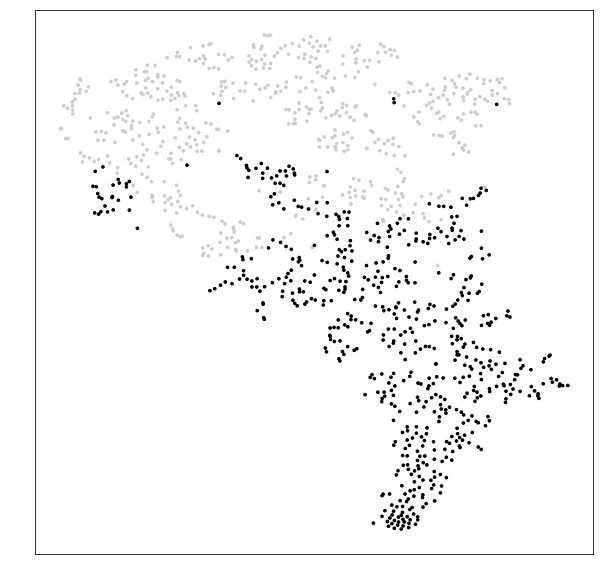

In [35]:
predictions = cluster.predict(df)

In [36]:
Counter(predictions)

Counter({0: 616, 1: 552})

In [37]:
v_measure_score(predictions, y)

0.19339414125368112

These results are pretty horrendous.

I'm guessing the reason for these horrendous results is because the good results are getting timeouts

### Experiment 2:

Research Question:
Does TSNE help us handle non-convex, clustering better?

The noisy moons is an excellent toy dataset for testing the algorithms performance agaisnt non-convex data

- For the output of noisy moons, classify and label each moon. These will be the ground truth for v_measure eval
- Run the algorithm, with TSNE, for 200 iterations, on the dataset
- check the v measure score
- Run the algorithm without TSNE, for 200 iterations, on the dataset
- check the v measure score
- Make note of the time taken, may be useful in the future when evaluating whether increased timecost is worthwhile

if the TSNE improves v measure score, then TSNE contributes to improved clustering
if it has no effect, it is unnecessary cost
if it makes it worse, the heuristic we are giving the algorithm causes the dimension reduction that warp the clusters

due to many of these processes being random, we may need to run multiple times

We may repeat this for evaluation heuristics that value continuity, as suggested by prof. ottos

In [1]:
import os

# change working directory, run this cell once
os.chdir("../")

In [2]:
# we will be using sample datasets in sklearn
from sklearn import datasets, cluster
from collections import Counter
import pandas as pd

# autocluster functionalities
from autocluster import AutoCluster
from evaluators import get_evaluator
from utils.metafeatures import MetafeatureMapper

%load_ext autoreload
%autoreload 2

In [8]:
X,y = datasets.make_moons(n_samples=1000, noise=.05, random_state=27)

dummy_df = pd.DataFrame(y)
dummy_df.head(5)
dummy_df = pd.DataFrame(X)
dummy_df.head(5)

,0,1
0,1.064207,-0.542808
1,1.119585,-0.420220
2,1.030609,0.230317
3,0.902470,0.287562
4,-1.013513,0.294588


In [9]:
print("Shape of this dataframe is {}".format(dummy_df.shape))

Shape of this dataframe is (1000, 2)


In [12]:
cluster = AutoCluster()
fit_params = {
    "df": dummy_df, 
    "cluster_alg_ls": [
        'KMeans', 'GaussianMixture', 'MiniBatchKMeans'
    ], 
    "dim_reduction_alg_ls": [
        'NullModel'
    ],
    "optimizer": 'smac',
    "n_evaluations": 150,
    "run_obj": 'quality',
    "seed": 27,
    "cutoff_time": 10,
    "preprocess_dict": {
        "numeric_cols": list(range(2)),
        "categorical_cols": [],
        "ordinal_cols": [],
        "y_col": []
    },
    "evaluator": get_evaluator(evaluator_ls = ['silhouetteScore', 
                                               'daviesBouldinScore', 
                                               'calinskiHarabaszScore'], 
                               weights = [1, 1, 1], 
                               clustering_num = None, 
                               min_proportion = .01, 
                               min_relative_proportion='default'),
    "n_folds": 3,
    "warmstart": False,
    "verbose_level": 1,
}
result_dict = cluster.fit(**fit_params)

900/1000 datapoints remaining after outlier removal
Truncated n_evaluations: 150
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 5, 'clustering_choice': 'KMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.29738815089379317
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 13, 'batch_size___MiniBatchKMeans': 958, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.24446478434262067
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'init_params___GaussianMixture': 'kmeans', 'covariance_type___GaussianMixture': 'spherical', 'n_components___GaussianMixture': 60, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 2, 'batch_size___MiniBatchKMeans': 969, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.3015639113538986
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 7, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.25580731687708486
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 19, 'batch_size___MiniBatchKMeans': 250, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.2565570224630112
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 25, 'clustering_choice': 'KMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.2651251625465206
Fitting configuration: 
{'dim_reduction_choice': 'NullModel

Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 80, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 69, 'batch_size___MiniBatchKMeans': 864, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 65, 'batch_size___MiniBatchKMeans': 850, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 1, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 4, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.32615331982467016
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'tied', 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'kmeans', 'n_components___GaussianMixture': 24, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: 0.2654116676876534
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'init_params___GaussianMixture': 'kmeans', 'covariance_type___GaussianMixture': 'tied', 'n_components___GaussianMixture': 30, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'n_components___GaussianMixture': 67, 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'random', 'covariance_type___GaussianMixture': 'spherical', 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 35, 'batch_size___MiniBatchKMeans': 664, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.28282434909425985
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 16, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.24761368698853914
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 53, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'spherical', 'random_state___NullModel': 1, 'init_params___GaussianMixture': 'random', 'n_components___GaussianMixture': 53, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'spherical', 'random_state___NullModel': 1, 'init_params___GaussianMixture': 'kmeans', 'n_components___GaussianMixture': 4, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: 0.33026643906185355
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 8, 'batch_size___MiniBatchKMeans': 82, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.2593561094865407
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 55, 'batch_size___MiniBatchKMeans': 168, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 6, 'batch_size___MiniBatchKMeans': 711, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.28349899156830705
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'full', 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'kmeans', 'n_components___GaussianMixture': 1, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 79, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 24, 'batch_size___MiniBatchKMeans': 153, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.26712473227316574
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 52, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 11, 'batch_size___MiniBatchKMeans': 76, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.2479377749634142
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 57, 'batch_size___MiniBatchKMeans': 417, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 43, 'batch_size___MiniBatchKMeans': 83, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 38, 'batch_size___MiniBatchKMeans': 661, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.29277968280598715
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 38, 'batch_size___MiniBatchKMeans': 777, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 7, 'batch_size___MiniBatchKMeans': 467, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.26015073178333076
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'tied', 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'kmeans', 'n_components___GaussianMixture': 32, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 29, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: 0.27192299147371884
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 36, 'batch_size___MiniBatchKMeans': 230, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 73, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 61, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 34, 'batch_size___MiniBatchKMeans': 447, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 35, 'batch_size___MiniBatchKMeans': 479, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'full', 'init_params___GaussianMixture': 'kmeans', 'n_components___GaussianMixture': 73, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'n_components___GaussianMixture': 79, 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'kmeans', 'covariance_type___GaussianMixture': 'tied', 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 25, 'batch_size___MiniBatchKMeans': 64, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.2701839457939104
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 25, 'batch_size___MiniBatchKMeans': 27, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 33, 'clustering_choice': 'KMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'init_params___GaussianMixture': 'kmeans', 'covariance_type___GaussianMixture': 'full', 'n_components___GaussianMixture': 37, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 11, 'batch_size___MiniBatchKMeans': 380, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.24254187273465236
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 11, 'batch_size___MiniBatchKMeans': 416, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.2434232339993927
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 65, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 21, 'batch_size___MiniBatchKMeans': 412, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 9, 'batch_size___MiniBatchKMeans': 184, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.24697485748308565
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 9, 'batch_size___MiniBatchKMeans': 351, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.24747008810071347
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 9, 'batch_size___MiniBatchKMeans': 55, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.24774163670362795
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 9, 'batch_size___MiniBatchKMeans': 51, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.24948876260831732
Fitting conf

Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 14, 'batch_size___MiniBatchKMeans': 266, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.24793371977436254
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 11, 'batch_size___MiniBatchKMeans': 400, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.24615604026259877
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 13, 'batch_size___MiniBatchKMeans': 444, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.24557841749965162
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'full', 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'random', 'n_components___GaussianMixture': 15, 'clustering_choice':

Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 9, 'batch_size___MiniBatchKMeans': 405, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.2457047002721547
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 55, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 11, 'batch_size___MiniBatchKMeans': 234, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.23981118221751532
Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'n_components___GaussianMixture': 41, 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'kmeans', 'covariance_type___GaussianMixture': 'tied', 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 15, 'batch_size___MiniBatchKMeans': 380, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.25377663830944175
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 9, 'batch_size___MiniBatchKMeans': 180, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.24731016677589976
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 9, 'batch_size___MiniBatchKMeans': 186, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.24444227928020246
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 56, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'tied', 'random_state___NullModel': 1, 'init_params___GaussianMixture': 'random', 'n_components___GaussianMixture': 26, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'diag', 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'kmeans', 'n_components___GaussianMixture': 65, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'spherical', 'random_state___NullModel': 1, 'init_params___GaussianMixture': 'random', 'n_components___GaussianMixture': 15, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 66, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 1, 'batch_size___MiniBatchKMeans': 380, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 9, 'batch_size___MiniBatchKMeans': 450, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.24404990733795354
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'tied', 'random_state___NullModel': 1, 'init_params___GaussianMixture': 'random', 'n_components___GaussianMixture': 65, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 7, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: 0.25627891961778065
Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'n_components___GaussianMixture': 35, 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'kmeans', 'covariance_type___GaussianMixture': 'diag', 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 21, 'batch_size___MiniBatchKMeans': 460, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.2660382651504439
Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'tied', 'init_params___GaussianMixture': 'random', 'n_components___GaussianMixture': 55, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 64, 'batch_size___MiniBatchKMeans': 731, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'init_params___GaussianMixture': 'random', 'covariance_type___GaussianMixture': 'full', 'n_components___GaussianMixture': 9, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 10, 'batch_size___MiniBatchKMeans': 983, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.2482572618685238
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 11, 'batch_size___MiniBatchKMeans': 815, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.24294303448317256
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 28, 'batch_size___MiniBatchKMeans': 93, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.27278326846167705
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 66, 'batch_size___MiniBatchKMeans': 886, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuratio

Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 61, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 9, 'batch_size___MiniBatchKMeans': 874, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.25128014827126727
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 19, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: 0.24641691193029072
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 52, 'clustering_choice': 'KMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 23, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: 0.25739436310396435
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 24, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: 0.2601156348082565
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 49, 'clustering_choice': 'KMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 12, 'clustering_choice': 'KMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.2430206442726457
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 2, 'batch_size___MiniBatchKMeans': 160, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.30186342683548184
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 31, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: 0.2765465313473809
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 78, 'batch_size___MiniBatchKMeans': 574, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 28, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 14, 'batch_size___MiniBatchKMeans': 376, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.2485355338853967
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 14, 'batch_size___MiniBatchKMeans': 419, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.2444946746644471
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 4, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: 0.32824437337180484
Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'n_components___GaussianMixture': 17, 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'random', 'covariance_type___GaussianMixture': 'diag', 'clustering_choice': 'GaussianMixture'}
Score obtained by this configur

Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 14, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.24357216166072404
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 41, 'clustering_choice': 'KMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'n_components___GaussianMixture': 22, 'random_state___NullModel': 1, 'init_params___GaussianMixture': 'kmeans', 'covariance_type___GaussianMixture': 'full', 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: 0.3373898964685211
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'spherical', 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'random', 'n_components___GaussianMixture': 44, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 23, 'clustering_choice': 'KMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.2636858080331534
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 7, 'clustering_choice': 'KMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: 0.25569794214482494
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 38, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 11, 'batch_size___MiniBatchKMeans': 177, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.24575934830343327
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 15, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: 0.24511547043442872
Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'spherical', 'init_params___GaussianMixture': 'random', 'n_components___GaussianMixture': 4, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: 0.39138010730028955
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 10, 'batch_size___MiniBatchKMeans': 818, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.245307260416749

Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'n_components___GaussianMixture': 38, 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'random', 'covariance_type___GaussianMixture': 'diag', 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'tied', 'random_state___NullModel': 2, 'init_params___GaussianMixture': 'random', 'n_components___GaussianMixture': 56, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 18, 'batch_size___MiniBatchKMeans': 513, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.2553922801424551
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 18, 'batch_size___MiniBatchKMeans': 427, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: 0.25671967584314453
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 10, 'batch_size___MiniBatchKMeans': 417, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.24835821143737993
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 10, 'batch_size___MiniBatchKMeans': 408, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.2447717264228376
Fitting 

Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 11, 'batch_size___MiniBatchKMeans': 116, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.24467994166332985
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 11, 'batch_size___MiniBatchKMeans': 111, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.24546614118646615
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 20, 'batch_size___MiniBatchKMeans': 873, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.2576530825789358
Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'n_components___GaussianMixture': 13, 'random_state___NullModel': 1, 'init_params___GaussianMixture': 'random

Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 35, 'clustering_choice': 'KMeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 13, 'batch_size___MiniBatchKMeans': 767, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: 0.2472896733684589
Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'n_clusters___KMeans': 54, 'clustering_choice': 'KMeans', 'random_state___NullModel': 2}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 80, 'batch_size___MiniBatchKMeans': 544, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 70, 'batch_size___MiniBatchKMeans': 355, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans'}
Score obtained by this configuration: inf


Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'n_components___GaussianMixture': 24, 'random_state___NullModel': 1, 'init_params___GaussianMixture': 'kmeans', 'covariance_type___GaussianMixture': 'full', 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'n_components___GaussianMixture': 25, 'random_state___NullModel': 1, 'init_params___GaussianMixture': 'kmeans', 'covariance_type___GaussianMixture': 'full', 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: 0.355541044171694
Fitting configuration: 
{'n_clusters___MiniBatchKMeans': 67, 'batch_size___MiniBatchKMeans': 334, 'dim_reduction_choice': 'NullModel', 'clustering_choice': 'MiniBatchKMeans', 'random_state___NullModel': 1}
Score obtained by this configuration: inf


Fitting configuration: 
{'warm_start___GaussianMixture': True, 'dim_reduction_choice': 'NullModel', 'n_components___GaussianMixture': 78, 'random_state___NullModel': 1, 'init_params___GaussianMixture': 'kmeans', 'covariance_type___GaussianMixture': 'spherical', 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Fitting configuration: 
{'dim_reduction_choice': 'NullModel', 'covariance_type___GaussianMixture': 'full', 'random_state___NullModel': 1, 'init_params___GaussianMixture': 'kmeans', 'n_components___GaussianMixture': 35, 'clustering_choice': 'GaussianMixture'}
Score obtained by this configuration: inf


Optimization is complete.
Took 123.2 seconds.
The optimal configuration is 
Configuration:
  batch_size___MiniBatchKMeans, Value: 234
  clustering_choice, Value: 'MiniBatchKMeans'
  dim_reduction_choice, Value: 'NullModel'
  n_clusters___MiniBatchKMeans, Value: 11
  random_state___NullModel, Value: 2



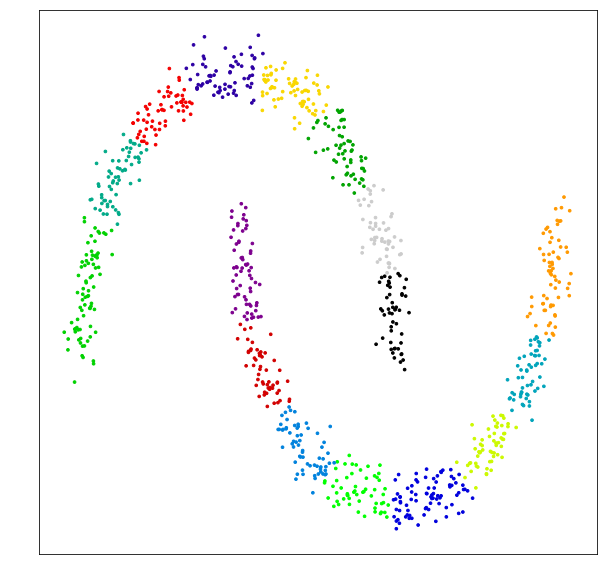

In [11]:
predictions = cluster.predict(dummy_df)